# Importing libraries

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm

%matplotlib inline

# Loading data

In [2]:
file_name = 'amz_uk_price_prediction_dataset.csv'

In [3]:
df = pd.read_csv(file_name)

# Part 1: Analyzing Best-Seller Trends Across Product Categories

#### Crosstab Analysis

In [9]:
df.head()
# df['isBestSeller'].unique()  -- False, True
# df.shape[0]  --2443651

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [81]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [82]:
# Creating a bestseller percentage column for the percentage
crosstab_result["BestSeller_Percentage"] = crosstab_result.iloc[:,1]/(crosstab_result.iloc[:, 0:2].sum(axis=1))*100
crosstab_result["BestSeller_Percentage"].sort_values(ascending = False).head(10)

category
Grocery                           5.813467
Smart Home Security & Lighting    5.769231
Health & Personal Care            5.768628
Mobile Phone Accessories          4.247104
Power & Hand Tools                3.533895
Billiard, Snooker & Pool          3.212851
Pet Supplies                      3.020028
Home Brewing & Wine Making        2.845528
Wind Instruments                  2.800000
Mirrors                           2.800000
Name: BestSeller_Percentage, dtype: float64

It seems that the categories "Grocery", "Smart Home Security & Lighting" and "Health & Personal Care" have more bestsellers.

#### Statistical Tests

In [83]:
crosstab_result

isBestSeller,False,True,BestSeller_Percentage
category,,,
3D Printers,247,1,0.403226
3D Printing & Scanning,4065,2,0.049176
Abrasive & Finishing Products,245,5,2.000000
Action Cameras,1696,1,0.058928
Adapters,251,3,1.181102
...,...,...,...
Wind Instruments,243,7,2.800000
Window Treatments,234,5,2.092050
Women,17559,213,1.198515


In [85]:
# Chi-square test for category and isBestSeller -excluding the column I did with percentage
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result.iloc[:, :-1])
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

The p-value seems to be 0.0. If that is correct, that means that my null hypothesis is rejected, meaning that there is some association between category and best-seller distribution.

In [88]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result.iloc[:, :-1], method="cramer")

0.1222829439760564

The very low Cramér's V value of 0.122 suggests a weak association between the two variables.

# Part 2: Exploring Product Prices and Ratings Across Categories and Brands

#### Preliminary Step: Remove outliers in product prices

In [90]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [91]:
outliers = tukeys_test_outliers(df["price"])

In [108]:
# df["price"].shape[0] -- 2443651
# outliers -- 327688

In [104]:
# transforming it to list to use it for filtering
outliers_list = outliers.values.tolist()

In [106]:
df_filtered = df[~df["price"].isin(outliers_list)]

#### Violin Plots

In [157]:
top_20_categories = df_filtered["category"].value_counts().head(20).index

In [135]:
df_top_20_categories = df_filtered[df_filtered["category"].isin(top_20_categories)]

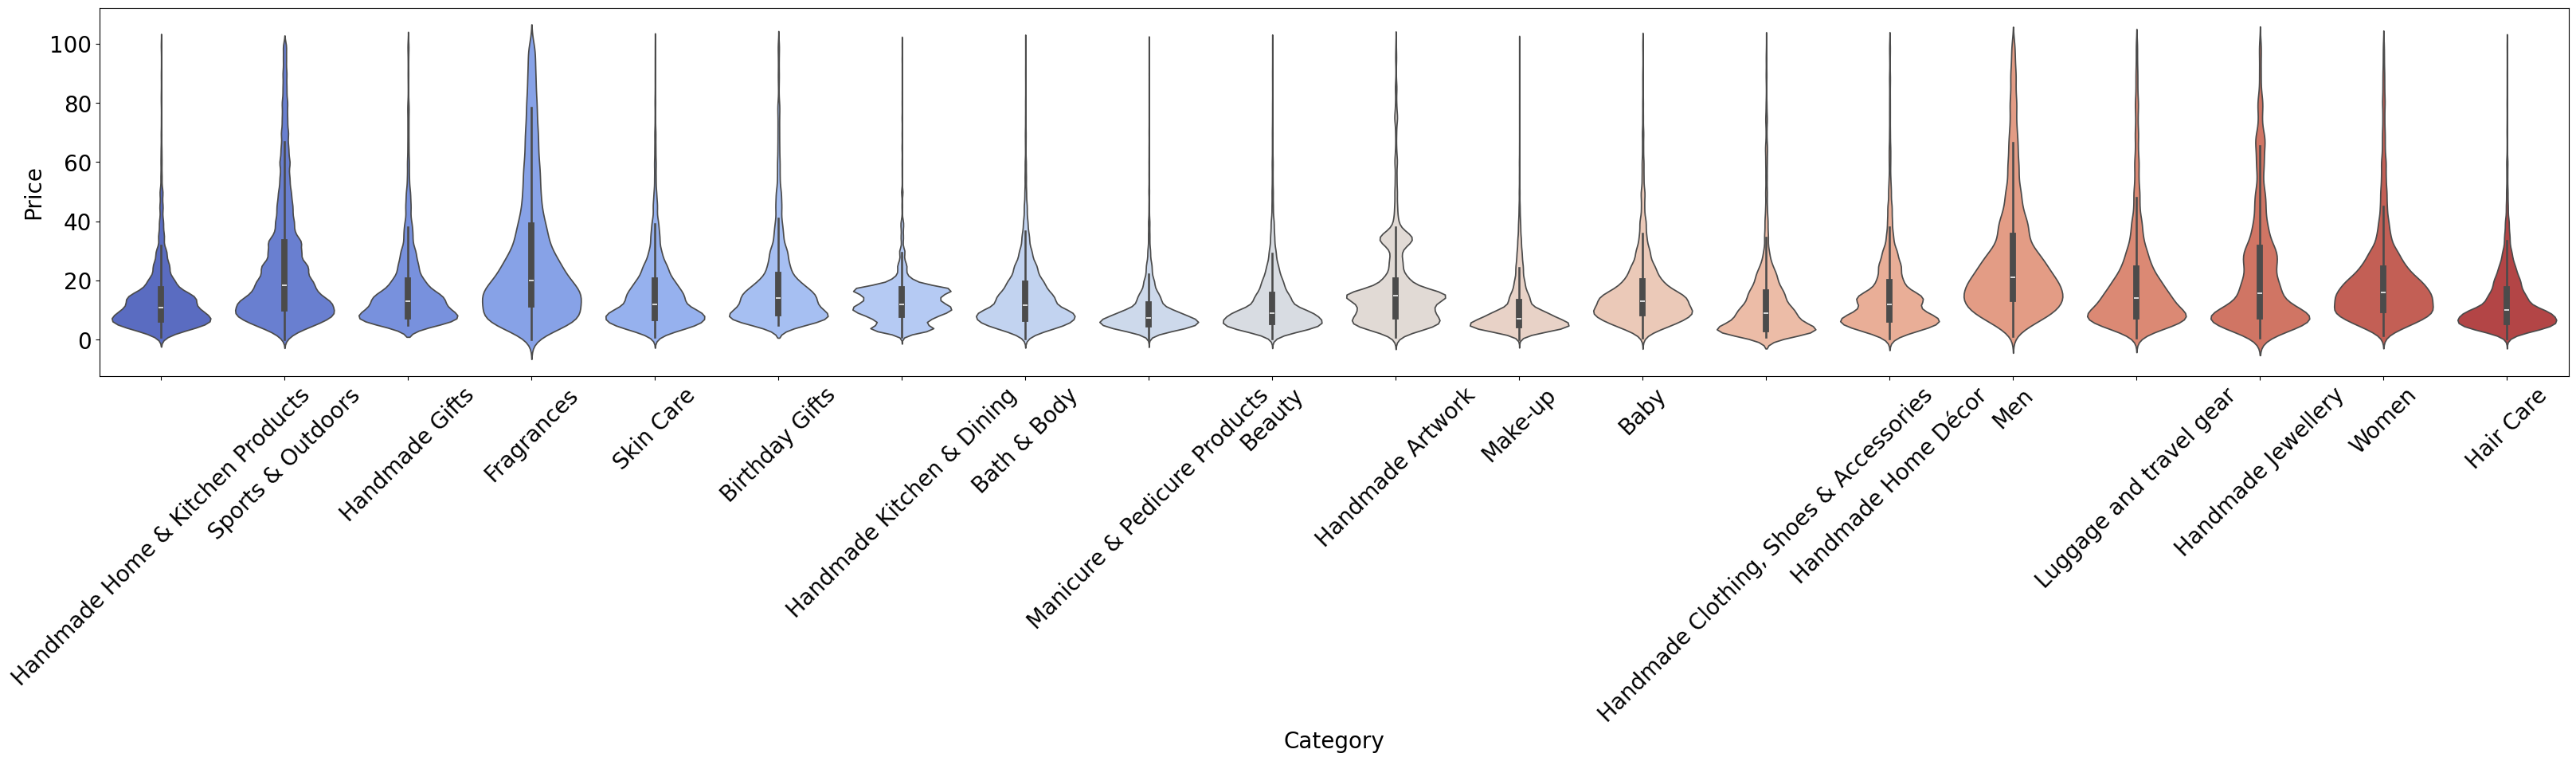

In [146]:
plt.figure(figsize=(40, 6))

sns.violinplot(data=df_top_20_categories, x='category', y='price', 
               palette="coolwarm", hue = 'category', legend= False)

plt.xlabel('Category', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.show()

In [154]:
df_filtered.groupby("category")["price"].median().sort_values(ascending=False)

category
Desktop PCs              74.00
Boxing Shoes             69.79
Tablets                  69.00
Graphics Cards           68.54
Motherboards             67.92
                         ...  
Adapters                  7.05
Make-up                   7.00
Signs & Plaques           6.99
Arts & Crafts             5.99
Office Paper Products     4.37
Name: price, Length: 296, dtype: float64

The product with the highest median price is "Desktop PCs".

#### Bar Charts

In [156]:
top_10_categories = df_filtered["category"].value_counts().head(10).index

In [158]:
df_top_10_categories = df_filtered[df_filtered["category"].isin(top_10_categories)]

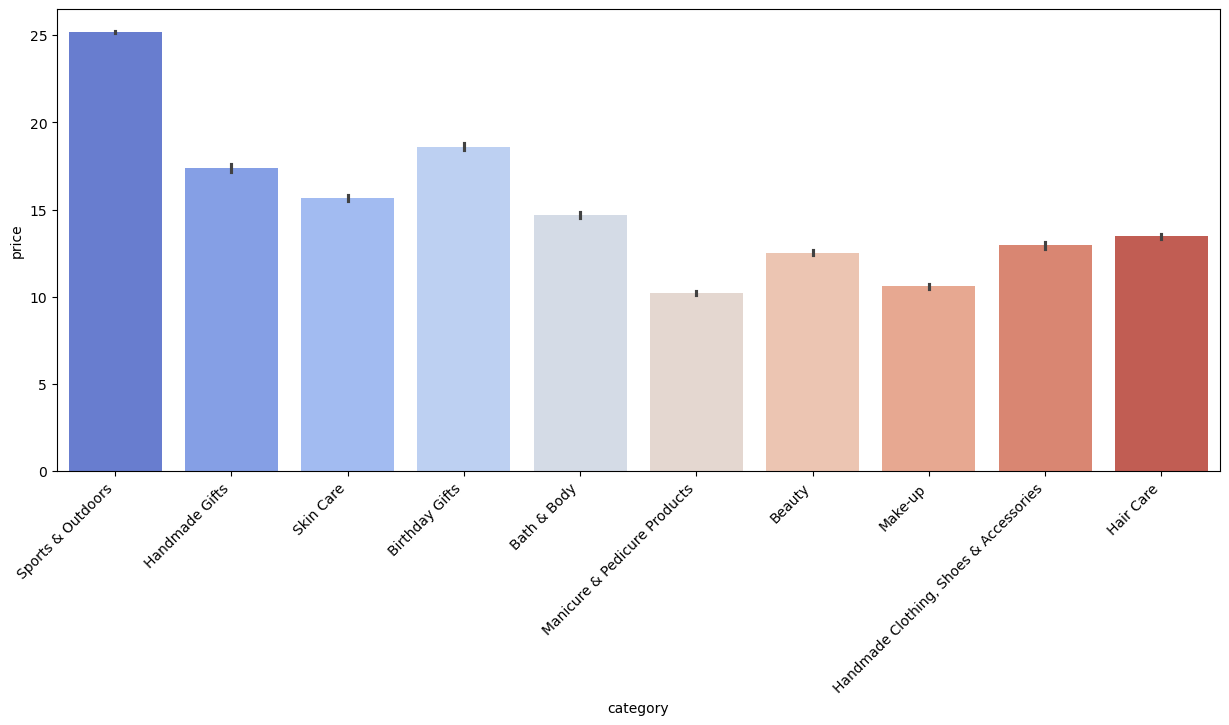

In [167]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_top_10_categories, x='category', y='price', palette="coolwarm", hue= 'category', legend=False)

plt.xticks(rotation=45, ha='right')

plt.show()

In [168]:
df_filtered.groupby("category")["price"].mean().sort_values(ascending=False)

category
Motherboards             68.772432
Boxing Shoes             67.417803
Desktop PCs              66.915562
Tablets                  66.552971
Graphics Cards           65.103509
                           ...    
Bedding Accessories       8.835220
Adapters                  8.750197
Signs & Plaques           8.210513
Arts & Crafts             8.006540
Office Paper Products     6.876369
Name: price, Length: 296, dtype: float64

The product with the highest mean price is "Motherboards".

#### Box Plots

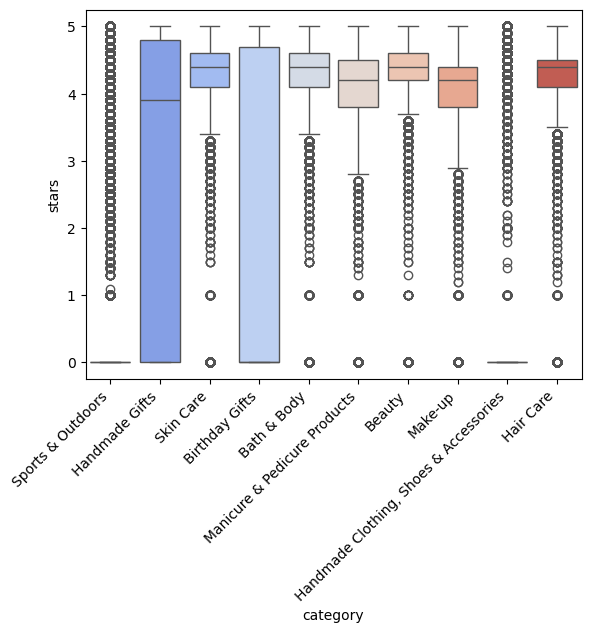

In [174]:
sns.boxplot(data=df_top_10_categories, x='category', y='stars', palette="coolwarm", hue = 'category', legend = False)

plt.xticks(rotation=45, ha='right')

plt.show()

df_filtered.groupby("category")["stars"].median().sort_values(ascending=False)

In [179]:
df_filtered_without_0 = df_filtered[df_filtered["stars"] != 0.0]
df_filtered_without_0.groupby("category")["stars"].median().sort_values(ascending=False)

category
Made in Italy Handmade                    5.0
Handmade Baby Products                    5.0
Handmade Artwork                          5.0
Handmade Kitchen & Dining                 4.9
Handmade Clothing, Shoes & Accessories    4.9
                                         ... 
Mobile Phones & Smartphones               3.9
Media Streaming Devices                   3.8
Action Cameras                            3.8
Camcorders                                3.8
Motorbike Instruments                     3.7
Name: stars, Length: 296, dtype: float64

Upon investigating the ratings across different categories, it's evident that many products have a rating of 0, indicating no customer feedback. When considering the category with the highest median rating, "Computer Memory" initially emerges on top. However, after excluding these zero ratings, "Made in Italy Handmade" stands out as the category with the highest median rating from customers. 

# Part 3: Investigating the Interplay Between Product Prices and Ratings

#### Correlation Coefficients

In [189]:
correlation = df['price'].corr(df['stars'])
correlation

-0.12490673262148647

No, it doesn't seem to be correlation between product price and stars.

#### Visualizations

<Axes: xlabel='price', ylabel='stars'>

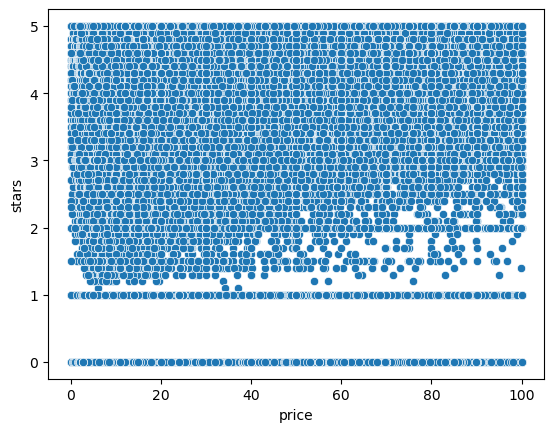

In [192]:
sns.scatterplot(data=df_filtered, x='price', y='stars')

<Axes: xlabel='price', ylabel='stars'>

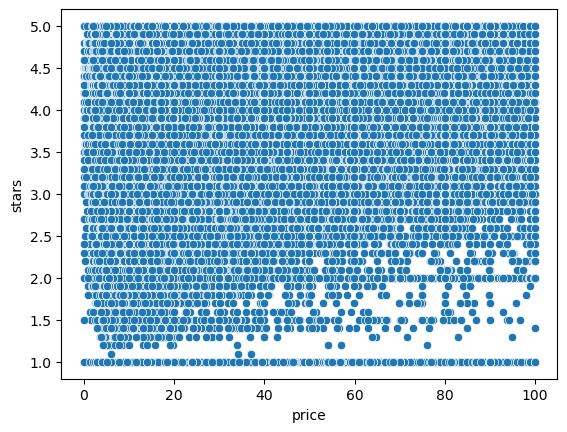

In [194]:
# testing also how the scatterplot looks without the 0 valeus
sns.scatterplot(data=df_filtered_without_0, x='price', y='stars')

Upon examining the relationship between product rating and price, no discernible pattern emerges. However, a minor observation suggests that products with higher prices tend to receive fewer ratings in the 1-2 star range.

In [ ]:
sns.heatmap(crosstab_result, annot=True, cmap="YlGnBu", fmt="d")

In [204]:
# df['uid'].duplicated().any() --> False
# Selecting the numerical variables, excluding the uid
df_numerical = df.select_dtypes("number").drop(columns = 'uid')
df_numerical

# double checking the categorical variables
#df_categorical = df.select_dtypes("object")
#df_categorical

,stars,reviews,price,boughtInLastMonth
0,4.7,15308,21.99,0
1,4.7,98099,23.99,0
2,4.7,15308,21.99,0
3,4.7,7205,31.99,0
4,4.6,1881,17.99,0
...,...,...,...,...
2443646,0.0,0,22.34,0
2443647,0.0,0,97.99,0
2443648,0.0,0,52.99,0
2443649,4.3,404,79.99,0


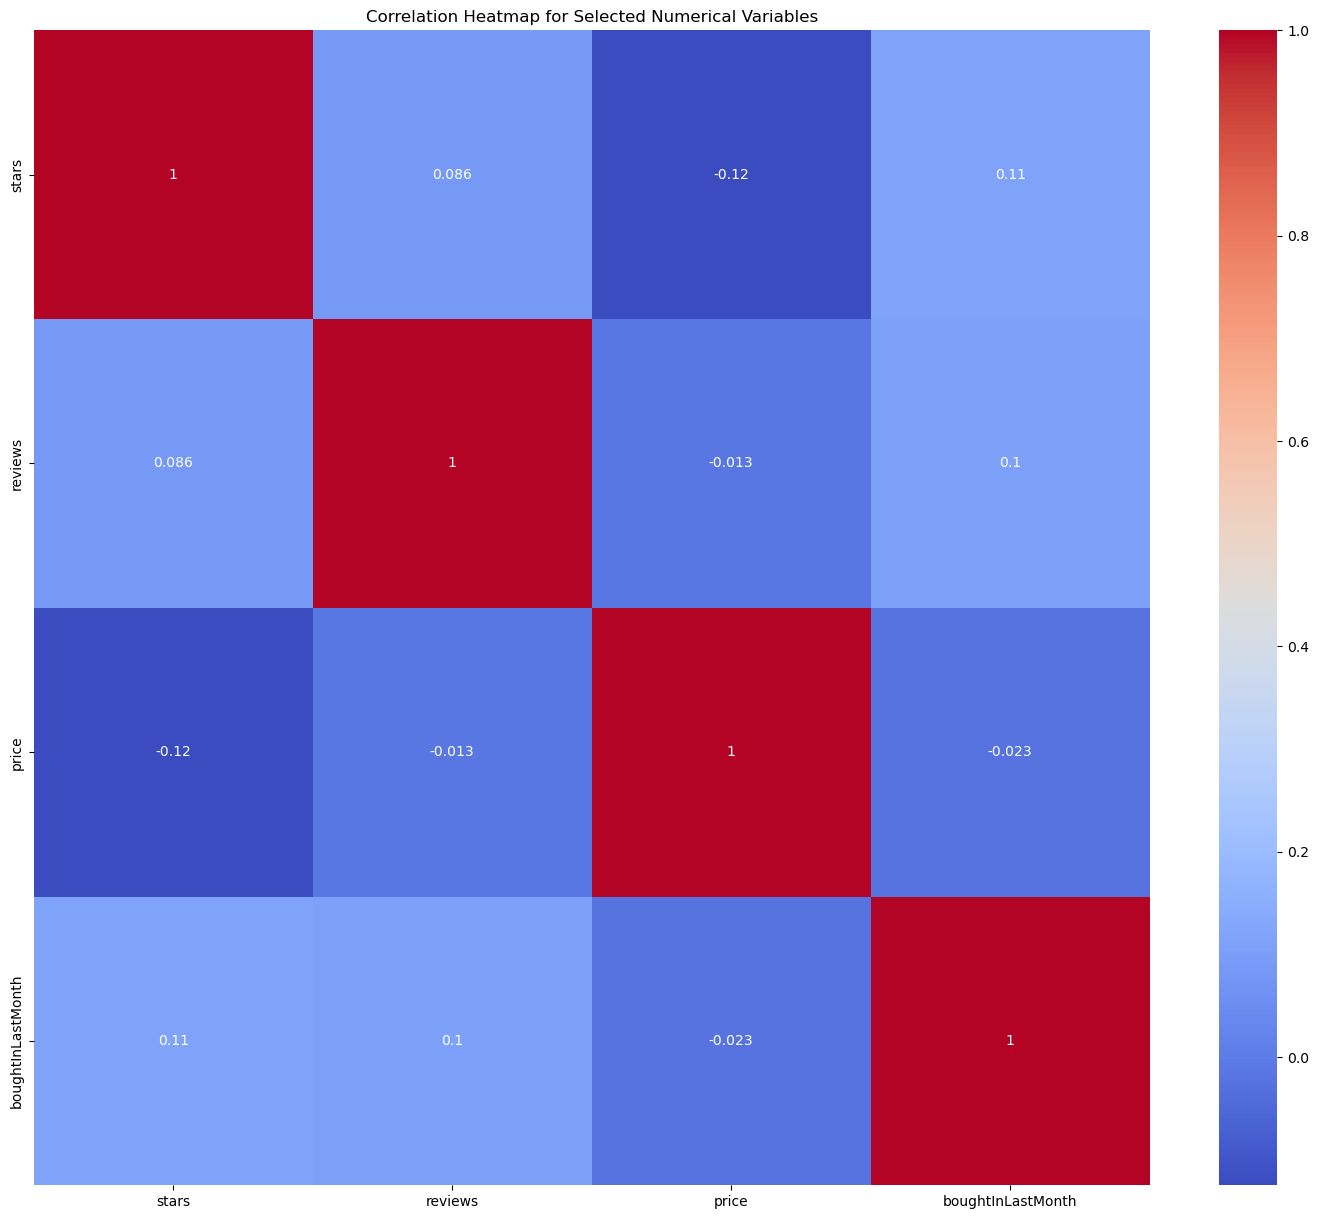

In [205]:
correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

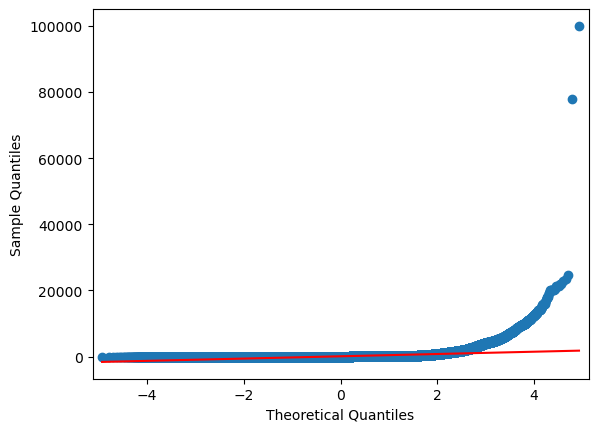

In [207]:
# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(df['price'], line='s');

In the upper tail (right side of the plot) the data points deviate significantly from the red line, suggesting a long tail or skewness to the right. The 'price' is not normally distributed.